In [1]:
import numpy as np
import scipy as sp

In [60]:
def sample_entry(M, cols, delta):
    
    print (delta)
    
    for i in cols:
        sample = np.random.choice(2, M.shape[1], p=[1 - delta, delta])
        new_col = np.multiply(M[:, i], sample)
        M[:, i] = new_col

    return M

#M = np.array([[1 , 1, 1],[2, 2, 2], [3, 3, 3]])
#print (M)

#new_M = sample_entry(M, [0, 2], 0.5)
#print (new_M)

In [61]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    
    print ("gauss random matrix shape ", omega.shape)
    
    _C = np.zeros(C.shape)
    # Trimming
    for i in range (C.shape[0]):
        if (np.count_nonzero(C[i,:]) > 10):
            _C[i,:] = 0
        else:
            _C[i,:] = C[i,:]
    print ("_C shape ", _C.shape)        
    
    F = _C.T @ _C - np.diag(np.diag( _C.T @ _C))
    
    print ("F shape ", F.shape)
    
    QR = (np.linalg.matrix_power(F, int(5 * np.log2(C.shape[1]))) @ omega)
    
    print ("QR shape ", QR.shape)
    
    ## TODO: power iteration ???
    ## Is log2 ???
    Q, R = np.linalg.qr(QR)
    
    return Q

In [62]:
def SLA(M, k, delta, l):
    
    print ("k ", k)
    print ("l ", l)
    print ("M shape ", M.shape)
    
    
    #l_samples = int (np.random.choice(M.shape[1], l))
    l_samples = list(np.random.randint(low = 0, high = M.shape[1], size = l))
    
    print ("sample len ", len(l_samples))
        
    sampled_M1 = sample_entry(M, l_samples, delta)
    sampled_M2 = sample_entry(M, l_samples, delta)
    
    A_b1 = sampled_M1[:, list(l_samples)]
    A_b2 = sampled_M2[:, list(l_samples)]
    
    print (A_b1)
    print (A_b2)
    
    print ("A_b1 shape ", A_b1.shape)
    
    
    _M = np.delete(M, list(l_samples), 1)
    
    Q = SPCA(A_b1, k)
    
    print ("Q shape ", Q.shape)
    
    for i in range (A_b2.shape[0]):
        if (np.count_nonzero(A_b2[i,:]) > 2):
            A_b2[i,:] = 0
    for i in range (A_b2.shape[1]):
        if (np.count_nonzero(A_b2[:,i]) > 10 * delta * A_b2.shape[0]):
            A_b2[:,i] = 0
    
    W = A_b2 @ Q
    V = np.zeros((M.shape[1], k))
    
    print (A_b1.shape)
    print (W.shape)
    print ((V[0:l,:]).shape)
    
    V[0:l,:] = (A_b1).T @ W
    
    
    #print (A_b1.T)
    #print (W)
    #print (V)
    
    ## FIXME: ??? what size ???
    I = np.zeros((M.shape[0], k))
    I = A_b1 @ V[0:l,:]
    
    ### TODO: Need to remove A_b1, A_b2 and Q from RAM
    
    for t in range (M.shape[1] - l):
        A_t = _M[:, t]
        V[t, :] = (A_t.T) @ W
        I += (A_t.reshape(-1, 1)) @ V[t,:].reshape(-1, 1).T
        ## TODO: remove A_t from RAM ???
    
    Q, R = np.linalg.qr(V)
    U = (1/delta)*(I @ R @ R.T)
    
    print (V)
    
    print (U)
    
    ## FIXME: Need to find out what is here in actual algorithm
    M_k = U @ V.T
    print (M_k.shape)
    
    return M_k
        

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests

url = 'https://cdn.icon-icons.com/icons2/10/PNG/256/check_ok_accept_apply_1582.png'
img_raw = Image.open(requests.get(url, stream=True).raw)
img = np.array(img_raw).astype(np.uint8)

img = img[:,:,3]
image = np.zeros(img.shape).astype(dtype=np.int)
image[img >= 1] = 1


print (image.shape)
print (image)
print (np.count_nonzero(image))
print (image.shape[0] * image.shape[1])

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
24485
65536


In [64]:
l = int(image.shape[1]/10)
delta = 1/(l * np.log2(image.shape[0]))

print (image)

M = SLA(image, int (np.linalg.matrix_rank(image) / 10), delta, l)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
k  23
l  25
M shape  (256, 256)
sample len  25
0.005
0.005
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
A_b1 shape  (256, 25)
gauss random matrix shape  (25, 23)
_C shape  (256, 25)
F shape  (25, 25)
QR shape  (25, 23)
Q shape  (25, 23)
(256, 25)
(256, 23)
(25, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(256, 256)


In [58]:
print (np.linalg.matrix_rank(M))

0


In [59]:
print (np.count_nonzero(M))

0


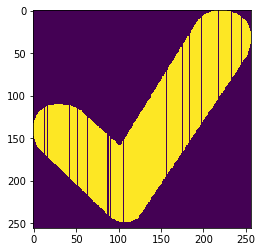

In [51]:
plt.imshow(image)

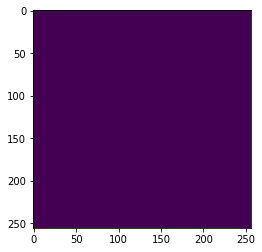

In [52]:
plt.imshow(M)